# Reto 2

## Miguel Ortiz y Andrea Castiella


In [1]:
import numpy  as np
import pandas as pd
import OurUtils as our
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [2]:
FullSet_0 = pd.read_csv('./Reto2-Datasets/1000_cero.csv', header=None)
FullSet_3 = pd.read_csv('./Reto2-Datasets/1000_tres.csv', header=None)
FullSet_6 = pd.read_csv('./Reto2-Datasets/1000_seis.csv', header=None)
FullSet_9 = pd.read_csv('./Reto2-Datasets/1000_nueve.csv', header=None)


# Scale image to range [0,1]
FullSet_0 = FullSet_0 / 255.0
FullSet_3 = FullSet_3 / 255.0
FullSet_6 = FullSet_6 / 255.0
FullSet_9 = FullSet_9 / 255.0

## Feature Engineering
- Feature multiplication
- Feature division

In [3]:
# Multiplies the value of two given characteristics
def feat_mult(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-5'):
    mult = features[feat1] * features[feat2]
    return pd.DataFrame({feat_name:mult})

# Divides the value of two given characteristics
def feat_div(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-4'):
    div = features[feat1] / (features[feat2] + 0.00001)
    return pd.DataFrame({feat_name:div})


## Feature extraction
Label for number 3: 0

Label for number 7: 1


In [4]:
FullSet = our.join_features_labels(FullSet_0, FullSet_3, FullSet_6, FullSet_9)
seed = 1234
theta = 0.5
X_full = our.feat_extraction( FullSet.drop('label', axis=1))
area = feat_mult(X_full, 'area', feat1='feat_7', feat2='feat_8')
X_full = pd.concat([X_full, area],axis=1)
mult_25 = feat_mult(X_full, 'mult_25', feat1='feat_2', feat2='feat_5')
X_full = pd.concat([X_full, mult_25],axis=1)
div_24 = feat_div(X_full, 'div_24', feat1='feat_2', feat2='feat_4')
X_full = pd.concat([X_full, div_24],axis=1)
#X_full.head()
Y_full = FullSet[['label']]
#print(np.unique(Y_full.values))


## Split dataset
Train split: 1600 samples (80%)

Validation split: 400 samples (20%)

In [5]:
valid_size = 0.1
splitter = StratifiedShuffleSplit(n_splits=1, test_size=valid_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)
for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

In [6]:
# Selected features after analyzing different combinations
feats = ['feat_9', 'div_24']
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train) # feats
Y = Y_train.values.ravel() # Returns data as numpy array


In [7]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC

base_clf = SVC(kernel='rbf', degree=2, gamma=1, random_state = seed) #<- it can be any other one

# Train OvO - SVM
OvO_clf = OneVsOneClassifier(base_clf)
OvO_clf.fit(X,Y)

# Train OvR - SVM
OvR_clf = OneVsRestClassifier(base_clf)
OvR_clf.fit(X,Y)

# Check
strlog = "OvO produces %d classifiers" %(len(OvO_clf.estimators_))
print(strlog)
strlog = "OvR produces %d classifiers" %(len(OvR_clf.estimators_))
print(strlog)


OvO produces 6 classifiers
OvR produces 4 classifiers


In [8]:
# Feature engineering, selection and rescaling to [0,1]
X_pred = scaler.transform(X_test) # feats
Y_true = Y_test.values.ravel()

# predict

Y_pred_OvO = OvO_clf.predict(X_pred)
Y_pred_OvR = OvR_clf.predict(X_pred)


In [9]:
# Performance metrics

conf_mat_OvO = confusion_matrix(Y_true, Y_pred_OvO)
hits_OvO = np.trace(conf_mat_OvO)
conf_mat_OvR = confusion_matrix(Y_true, Y_pred_OvR)
hits_OvR = np.trace(conf_mat_OvR)

# Print out
print("\nOvO confusion matrix:\n")
print(conf_mat_OvO)
print("\n")
print( "OvO Hits  = %d"%(hits_OvO) )
print( "OvO Fails = %d"%(Y_true.shape[0]-hits_OvO) )
print("\nOvR confusion matrix:\n")
print(conf_mat_OvR)
print( "\n")
print( "OvR Hits  = %d"%(hits_OvR) )
print( "OvR Fails = %d"%(Y_true.shape[0]-hits_OvR) )


OvO confusion matrix:

[[92  3  3  0]
 [ 3 89  2  6]
 [ 7  0 89  0]
 [ 1  3  0 96]]


OvO Hits  = 366
OvO Fails = 28

OvR confusion matrix:

[[93  4  1  0]
 [ 3 89  2  6]
 [ 6  0 90  0]
 [ 1  3  0 96]]


OvR Hits  = 368
OvR Fails = 26


In [10]:
# Load competition data
challenge_data = pd.read_csv('./reto2_X.csv', header=None)
challenge_data = challenge_data/255.0
# Feature extraction
challenge_features = our.feat_extraction(challenge_data)
area = feat_mult(challenge_features, 'area', feat1='feat_7', feat2='feat_8')
challenge_features = pd.concat([challenge_features, area],axis=1)
mult_25 = feat_mult(challenge_features, 'mult_25', feat1='feat_2', feat2='feat_5')
challenge_features = pd.concat([challenge_features, mult_25],axis=1)
div_24 = feat_div(challenge_features, 'div_24', feat1='feat_2', feat2='feat_4')
challenge_features = pd.concat([challenge_features, div_24],axis=1)
challenge_features = scaler.transform(challenge_features) # feats
# Inference
Y_chal_OvO = OvO_clf.predict(challenge_features)
Y_chal_OvR = OvR_clf.predict(challenge_features)

In [11]:
#np.savetxt('Reto2_OvO_Ypred.csv', Y_chal_OvO, fmt='%i', delimiter=',')
np.savetxt('Reto2_Ypred.csv', Y_chal_OvR, fmt='%i', delimiter=',')

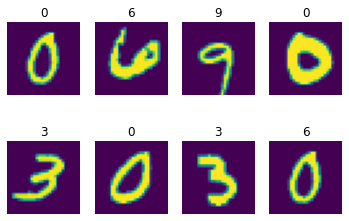

In [12]:
# Challenge images representation
from matplotlib import pyplot as plt
from numpy.random import default_rng
numb_img = 8
rng = default_rng()
numbers = rng.choice(4000, size=numb_img, replace=False)

chall_input = pd.read_csv('./reto2_X.csv', header=None)
chall_input = chall_input / 255.0
chall_input = chall_input.values.reshape([chall_input.shape[0],28,28])

chall_results = pd.read_csv('./Reto2_Ypred.csv', header=None)
chall_results = chall_results.values

images = np.zeros((numb_img,28,28))
img_labels = np.zeros((numb_img,))
for i in range(numb_img):
    images[i] = chall_input[numbers[i],:,:]
    img_labels[i] = chall_results[numbers[i]]


f, axarr = plt.subplots(2,4)
x, y = 0, 0
for i in range(images.shape[0]):

    img_y = img_labels[i]
    axarr[x,y].imshow(images[i])
    axarr[x,y].axis('off')
    axarr[x,y].title.set_text(str(int(img_y)))
    y = y + 1
    if y == axarr.shape[1]:
        y = 0
        x = x + 1
        
plt.imshow(images[0])